## Modelado Predictivo de Precios de Propiedades
# 
Este notebook implementa y compara varios modelos de regresión para predecir precios de propiedades.

## 1. Instalación e Importación de Librerías

In [1]:
# Instalación de paquetes
!pip install -q pandas scikit-learn xgboost plotly watermark

# %%
# Importaciones básicas
import pandas as pd
import numpy as np
from time import time
import warnings
warnings.filterwarnings('ignore')

# Preprocesamiento y modelado
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Métricas
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    mean_absolute_percentage_error, explained_variance_score,
    make_scorer
)

# Visualización
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración
pd.set_option('display.float_format', '{:,.2f}'.format)
np.random.seed(42)
sns.set_style('whitegrid')

## 2. Carga y Preparación de Datos

In [2]:
filepath = "../data/datos_limpios_eda.csv"

In [3]:
try:
    df = pd.read_csv(filepath)
    df = df[df["PrecioActual"] > 0].copy()

    price_related_cols = [col for col in df.columns if "precio" in col.lower() and col != "PrecioActual"]
    if price_related_cols:
        print(f"⚠️ Eliminando columnas relacionadas con el precio: {price_related_cols}")
        df = df.drop(columns=price_related_cols)

    df["PrecioLog"] = np.log(df["PrecioActual"])

    numeric_cols = df.select_dtypes(include=np.number).columns.drop(['PrecioActual', 'PrecioLog'])
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    print("\n🔍 Columnas identificadas:")
    print(f"Númericas: {numeric_cols.tolist()}")
    print(f"Categóricas: {categorical_cols.tolist()}")

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
        ])

    X = df.drop(columns=["PrecioActual", "PrecioLog"])
    y = df["PrecioActual"]
    y_log = df["PrecioLog"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    _, _, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

    print("\n✅ Datos cargados y preparados correctamente")
    print(f"📏 Dimensiones de X_train: {X_train.shape}")
    print(f"📏 Dimensiones de X_test: {X_test.shape}")
except Exception as e:
    print(f"\n❌ Error al cargar datos: {str(e)}")


⚠️ Eliminando columnas relacionadas con el precio: ['PrecioActual_log']

🔍 Columnas identificadas:
Númericas: ['metros', 'habitaciones', 'tiene_ascensor', 'planta_num', 'baños', 'Latitud', 'Longitud']
Categóricas: ['zona', 'localizacion']

✅ Datos cargados y preparados correctamente
📏 Dimensiones de X_train: (8268, 9)
📏 Dimensiones de X_test: (2068, 9)


## 3. Configuración de Modelos y Métricas

In [4]:
scoring = {
    'mae': make_scorer(mean_absolute_error, greater_is_better=False),
    'rmse': make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))), 
    'mape': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    'r2': make_scorer(r2_score),
    'evs': make_scorer(explained_variance_score)
}  

In [5]:
model_configs = {
    "Linear Regression": {
        "pipeline": Pipeline([
            ('preprocessor', preprocessor),
            ('model', LinearRegression())
        ]),
        "params": {
            'model__fit_intercept': [True, False]
        },
        "target": "normal"
    },
    "Ridge Regression": {
        "pipeline": Pipeline([
            ('preprocessor', preprocessor),
            ('model', Ridge())
        ]),
        "params": {
            'model__alpha': [0.1, 1.0, 10.0],
            'model__fit_intercept': [True, False]
        },
        "target": "normal"
    },
    "Random Forest": {
        "pipeline": Pipeline([
            ('preprocessor', preprocessor),
            ('model', RandomForestRegressor(random_state=42))
        ]),
        "params": {
            'model__n_estimators': [100, 200],
            'model__max_depth': [5, 10, 20],
            'model__min_samples_split': [2, 5]
        },
        "target": "normal"
    },
    "XGBoost": {
        "pipeline": Pipeline([
            ('preprocessor', preprocessor),
            ('model', XGBRegressor(random_state=42, verbosity=0))
        ]),
        "params": {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1],
            'model__max_depth': [3, 6]
        },
        "target": "normal"
    },
    "Gradient Boosting": {
        "pipeline": Pipeline([
            ('preprocessor', preprocessor),
            ('model', GradientBoostingRegressor(random_state=42))
        ]),
        "params": {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1],
            'model__max_depth': [3, 5]
        },
        "target": "normal"
    }
}

## 4. Entrenamiento de Modelos

In [6]:
trained_models = {}

In [ ]:
for name, config in model_configs.items():
    print(f"\n🔍 Entrenando {name}...")
    start_time = time()

    y_target = y_train_log if config.get("target") == "log" else y_train

    cv = GridSearchCV(
        config["pipeline"],
        config["params"],
        scoring=scoring,
        refit='r2',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    try:
        cv.fit(X_train, y_target)
        trained_models[name] = cv
        print(f"{name} entrenado en {time() - start_time:.2f} segundos")
        print(f"Mejores parámetros: {cv.best_params_}")
    except Exception as e:
        print(f"❌ Error entrenando {name}: {str(e)}")


🔍 Entrenando Linear Regression...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Linear Regression entrenado en 2.58 segundos

🔍 Entrenando Ridge Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ridge Regression entrenado en 2.00 segundos

🔍 Entrenando Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Random Forest entrenado en 16.35 segundos

🔍 Entrenando XGBoost...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
XGBoost entrenado en 1.24 segundos

🔍 Entrenando Gradient Boosting...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Gradient Boosting entrenado en 9.86 segundos


## 5. Evaluación de Modelos

In [8]:
resultados = []
predictions = {}

In [9]:
for name, model in trained_models.items():
    print(f"\Evaluando {name}...")
    start_time = time()

    try:
        y_pred = model.predict(X_test)
        predictions[name] = y_pred

        metrics = {
            "Modelo": name,
            "R2": r2_score(y_test, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
            "MAE": mean_absolute_error(y_test, y_pred),
            "MAPE": mean_absolute_percentage_error(y_test, y_pred),
            "Tiempo Pred (s)": time() - start_time
        }
        resultados.append(metrics)

        print(f"R²: {metrics['R2']:.4f}")
        print(f"RMSE: {metrics['RMSE']:,.2f}")
        print(f"MAE: {metrics['MAE']:,.2f}")

    except Exception as e:
        print(f"❌ Error evaluando {name}: {str(e)}")


\Evaluando Linear Regression...
R²: 0.7921
RMSE: 427,219.31
MAE: 262,312.80
\Evaluando Ridge Regression...
R²: 0.7921
RMSE: 427,181.74
MAE: 262,246.89
\Evaluando Random Forest...
R²: 0.8780
RMSE: 327,256.85
MAE: 175,094.09
\Evaluando XGBoost...
R²: 0.8730
RMSE: 333,886.48
MAE: 183,233.59
\Evaluando Gradient Boosting...
R²: 0.8721
RMSE: 335,108.25
MAE: 186,076.53


In [10]:
df_resultados = pd.DataFrame(resultados).set_index("Modelo").sort_values("R2", ascending=False)

## 6. Visualización de Resultados

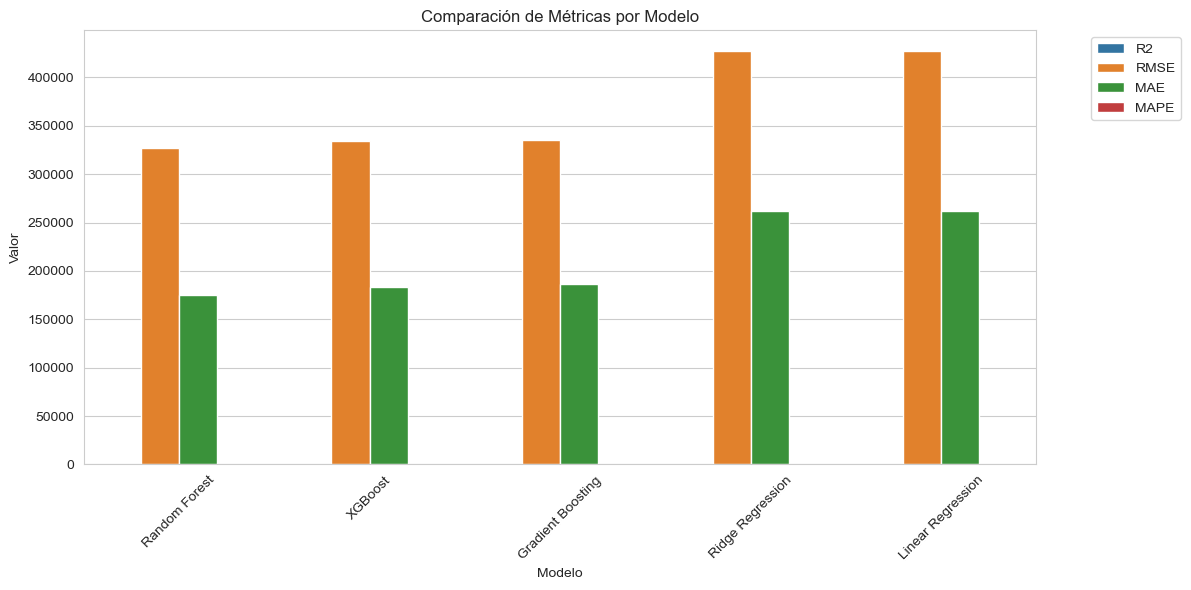

In [11]:
# Comparación de métricas
df_melted = df_resultados.reset_index().melt(
    id_vars="Modelo", 
    value_vars=["R2", "RMSE", "MAE", "MAPE"],
    var_name="Metrica", 
    value_name="Valor"
)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x="Modelo", y="Valor", hue="Metrica")
plt.title("Comparación de Métricas por Modelo")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

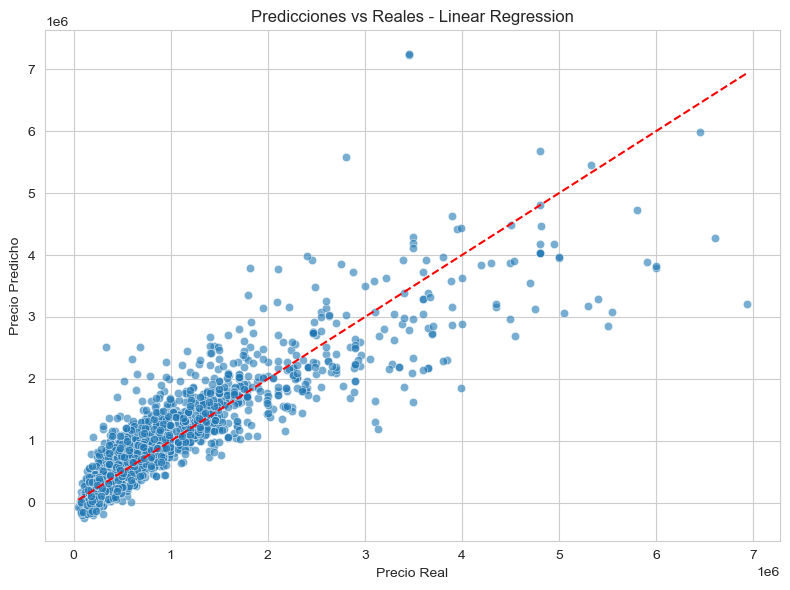

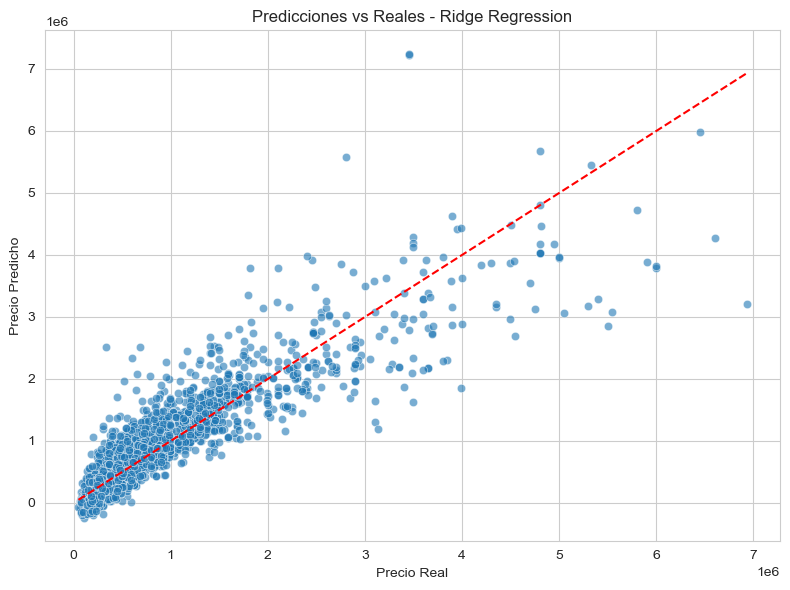

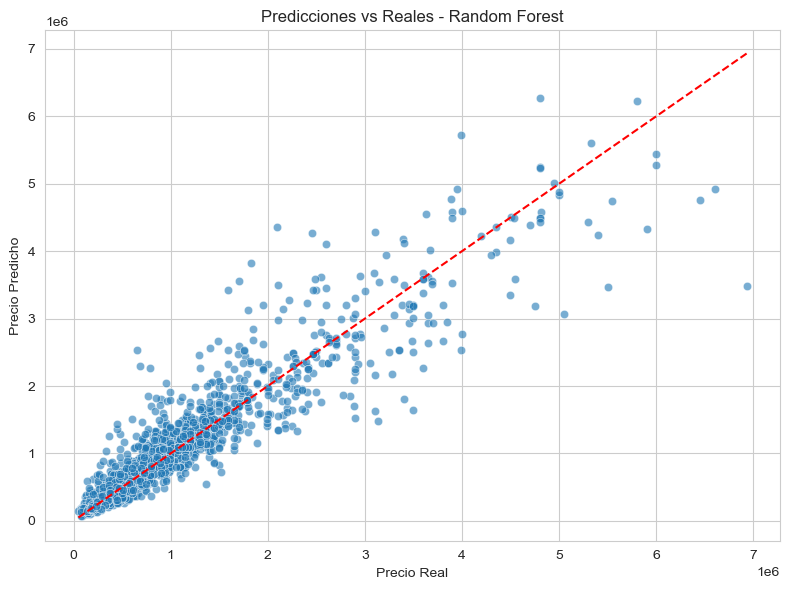

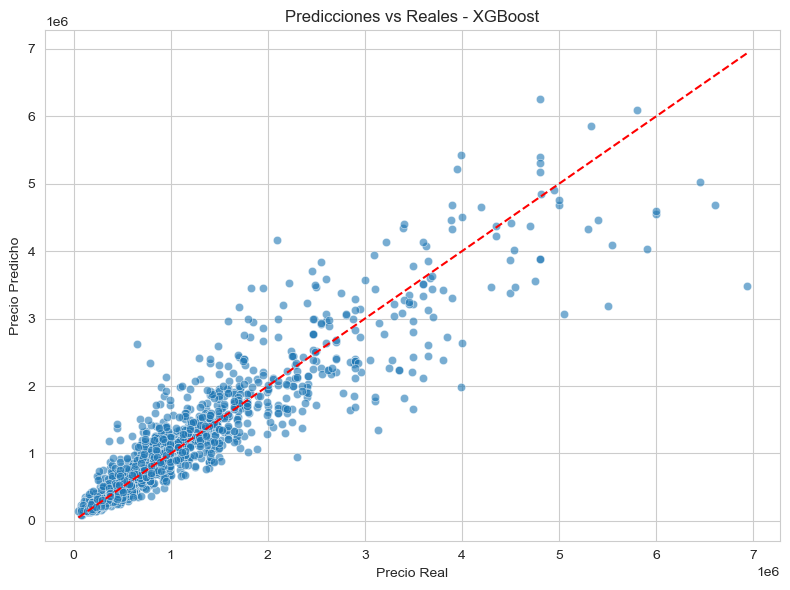

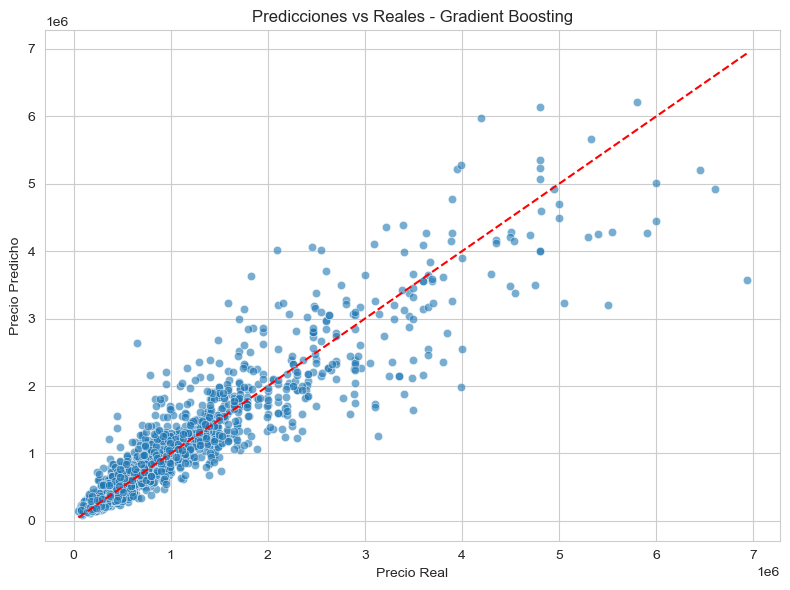

In [12]:
# Gráficos de predicción vs valor real
for name, pred in predictions.items():
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f'Predicciones vs Reales - {name}')
    plt.xlabel('Precio Real')
    plt.ylabel('Precio Predicho')
    plt.tight_layout()
    plt.show()